In [1]:
# ====================
# 1. IMPOR LIBRARY
# ====================
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# ====================
# 2. PERSIAPAN DATA
# ====================
# Memuat dataset
data = pd.read_csv('hcvdata.csv')

print("Missing values per column:")
print(data.isnull().sum())

# Mengatasi missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

for col in numeric_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        mode_value = data[col].mode()[0] if not data[col].mode().empty else 'unknown'
        data[col] = data[col].fillna(mode_value)

# Encoding label
le = LabelEncoder()
data['Category'] = le.fit_transform(data['Category'])
data['Sex'] = data['Sex'].map({'m': 0, 'f': 1})

print("\nData types after preprocessing:")
print(data.dtypes)
print(f"\nUnique categories in target: {np.unique(data['Category'])}")

# Menghapus kolom tidak perlu
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

# Memisahkan fitur dan target
X = data.drop(['Category'], axis=1)
y = data['Category']

# Standardisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

y_train = y_train.values
y_test = y_test.values

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y))}")

Missing values per column:
Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

Data types after preprocessing:
Unnamed: 0      int64
Category        int64
Age             int64
Sex             int64
ALB           float64
ALP           float64
ALT           float64
AST           float64
BIL           float64
CHE           float64
CHOL          float64
CREA          float64
GGT           float64
PROT          float64
dtype: object

Unique categories in target: [0 1 2 3 4]

Training set size: (492, 12)
Testing set size: (123, 12)
Number of classes: 5


In [3]:
# ====================
# 3. MEMBANGUN MODEL DNN
# ====================
class HCVClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HCVClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.output = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.output(x)
        return x

class HCVDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
learning_rate = 0.001
batch_size = 32
num_epochs = 100

print(f"\nModel Parameters:")
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes}")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {num_epochs}")

# Inisialisasi model, loss function, optimizer
model = HCVClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Membuat DataLoader
train_dataset = HCVDataset(X_train, y_train)
test_dataset = HCVDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Model Parameters:
Input size: 12
Number of classes: 5
Learning rate: 0.001
Batch size: 32
Epochs: 100


In [4]:
# ====================
# 4. PELATIHAN MODEL
# ====================
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(total_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss/len(test_loader))
    val_accuracies.append(100 * correct / total)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%')


Starting training...
Epoch [10/100], Train Loss: 0.6173, Val Loss: 0.5156, Train Acc: 88.62%, Val Acc: 91.06%
Epoch [20/100], Train Loss: 0.3356, Val Loss: 0.2682, Train Acc: 90.24%, Val Acc: 91.87%
Epoch [30/100], Train Loss: 0.3020, Val Loss: 0.2135, Train Acc: 90.65%, Val Acc: 92.68%
Epoch [40/100], Train Loss: 0.2561, Val Loss: 0.1706, Train Acc: 92.28%, Val Acc: 97.56%
Epoch [50/100], Train Loss: 0.2065, Val Loss: 0.1629, Train Acc: 92.68%, Val Acc: 97.56%
Epoch [60/100], Train Loss: 0.1935, Val Loss: 0.1381, Train Acc: 94.11%, Val Acc: 96.75%
Epoch [70/100], Train Loss: 0.1564, Val Loss: 0.1380, Train Acc: 95.33%, Val Acc: 95.93%
Epoch [80/100], Train Loss: 0.1421, Val Loss: 0.1421, Train Acc: 95.12%, Val Acc: 95.93%
Epoch [90/100], Train Loss: 0.1652, Val Loss: 0.1455, Train Acc: 95.93%, Val Acc: 95.93%
Epoch [100/100], Train Loss: 0.1410, Val Loss: 0.1349, Train Acc: 95.33%, Val Acc: 96.75%


In [5]:
# ====================
# 5. EVALUASI MODEL
# ====================
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    return all_preds, all_labels

y_pred, y_true = evaluate_model(model, test_loader)

print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Classification Report:
                        precision    recall  f1-score   support

         0=Blood Donor       0.98      1.00      0.99       107
0s=suspect Blood Donor       0.50      1.00      0.67         1
           1=Hepatitis       1.00      0.60      0.75         5
            2=Fibrosis       0.80      1.00      0.89         4
           3=Cirrhosis       1.00      0.67      0.80         6

              accuracy                           0.97       123
             macro avg       0.86      0.85      0.82       123
          weighted avg       0.97      0.97      0.97       123


Additional Metrics:
Accuracy: 0.9675
Precision: 0.9735
Recall: 0.9675
F1-Score: 0.9657


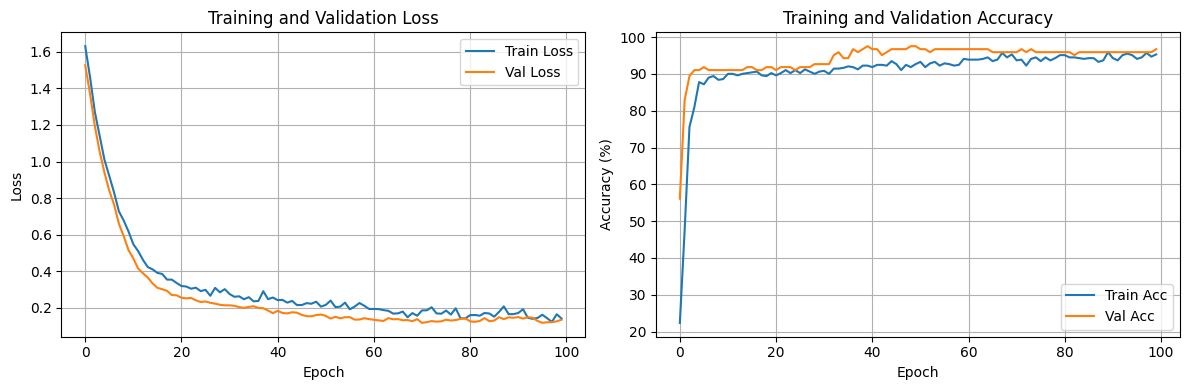

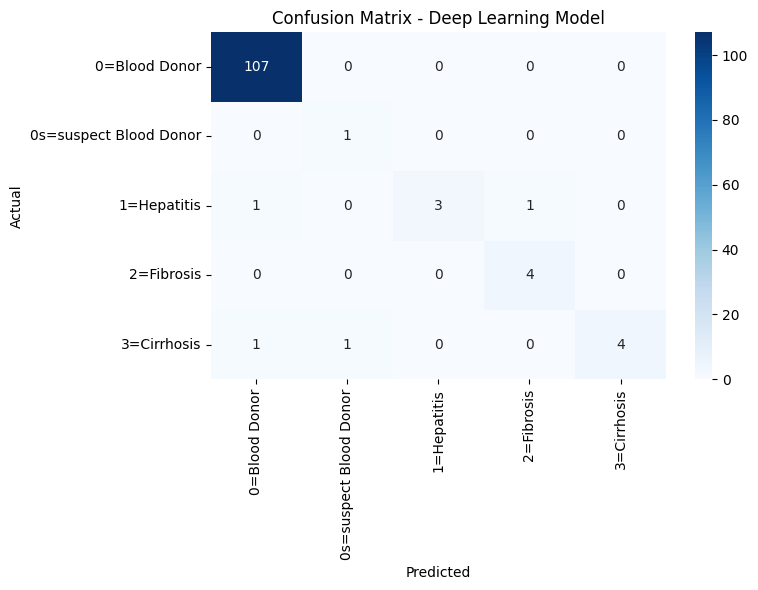

In [6]:
# ====================
# 6. VISUALISASI
# ====================
# Grafik Loss dan Akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Deep Learning Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [7]:
# ====================
# 7. MENYIMPAN MODEL
# ====================
torch.save(model.state_dict(), 'hcv_classifier.pth')
print("\nModel saved as 'hcv_classifier.pth'")


Model saved as 'hcv_classifier.pth'
